# ClimateNet AR Analysis: Hovmoller plots

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '5GiB' # PBSCluster specification
nmem2 = '5GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# the above is for jupyterhub only, otherwise use /proxy/{port}/status (also need to launch ssh tunneling from the appropriate environment)
#dask.config.set({'distributed.dashboard.link': "/proxy/{port}/status"})
# really I should set these options in some sort of config file...

# Setup your client
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.115:36763,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Set ClimateNet filepath

In [4]:
cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized

## Set regional bounds

In [5]:
# Western US domain from Payne & Magnusdottir (2014,2015) papers (estimated, modified to include land at all lons)
#lat_bounds = slice(25,61)
#lon_bounds = slice(189, 250)

# Restricted western US (mostly land) domain from Collow et al. 2020
#lat_bounds = slice(32,50)
#lon_bounds = slice(235,246)

# Western US/Eastern Pacific domain from ARTMIP
lat_bounds = slice(25,65)
lon_bounds = slice(180,255)

### Preprocessing function to subset regionally

In [6]:
def preprocess_region(ds):
    # return regional domain
    return ds['masks'].sel(lat=lat_bounds,lon=lon_bounds)

## CESM historical simulation

In [7]:
hist_yrs = [str(i) for i in range(2000,2006)]
#hist_folders = ["B20TRC5CN/"+y+"/masks/" for y in hist_yrs]
hist_folders = ["B20TRC5CN/"+y+"/masks_unwgt/" for y in hist_yrs] # unweighted means/std

In [9]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
hist_paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)]
#hist_paths

### Read in masks with preprocessing

In [10]:
%%time
cnet_hist_shift = xr.open_mfdataset(hist_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 4.92 s, sys: 288 ms, total: 5.21 s
Wall time: 1min 2s


In [11]:
cnet_hist_shift

<xarray.DataArray 'masks' (time: 17520, lat: 170, lon: 241)>
dask.array<concatenate, shape=(17520, 170, 241), dtype=int64, chunksize=(500, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### Shift time indices of 2000-2005 back 3hrs to avoid duplicative index

In [12]:
timeshift = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"H")
#timeshift

/glade/derecho/scratch/kdagon/tmp/ipykernel_25465/717251679.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  timeshift = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"H")


In [13]:
cnet_hist = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).assign_coords(time=timeshift)
cnet_hist

<xarray.DataArray 'masks' (time: 17520, lat: 170, lon: 241)>
dask.array<concatenate, shape=(17520, 170, 241), dtype=int64, chunksize=(500, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 00:00:00 ... 2005-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## CESM RCP2.6 simulation

In [16]:
rcp26_yrs = [str(i) for i in range(2006,2016)]
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks/" for y in rcp26_yrs]
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_v2/" for y in rcp26_yrs] # updated data processing (3hrly PSL)
rcp26_folders = ["BRCP26C5CN/"+y+"/masks_unwgt/" for y in rcp26_yrs] # unweighted means/std

In [17]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp26_paths = [cesm_cnet_filepath+rcp26_folders[i]+cnet_file for i,f in enumerate(rcp26_folders)]
#rcp26_paths

### Read in masks with preprocessing

In [20]:
%%time
cnet_rcp26 = xr.open_mfdataset(rcp26_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)
cnet_rcp26

CPU times: user 396 ms, sys: 55.3 ms, total: 452 ms
Wall time: 2.4 s


<xarray.DataArray 'masks' (time: 29200, lat: 170, lon: 241)>
dask.array<concatenate, shape=(29200, 170, 241), dtype=int64, chunksize=(500, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2006-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    np:                         4
    ne:                         120
    case:                       b.e13.BRCP26C5CN.ne120_g16.003
    ...                         ...
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/p/cgd/amp/jet/mapfiles/map_ne120_to_dl...
    input_file:                 /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    history_of_appended_files:  Mon Apr  3 10:28:39 2023: Appended file 2006_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## Combine historical/RCP2.6

In [21]:
cnet_hist_rcp26 = xr.concat([cnet_hist, cnet_rcp26], dim='time')
cnet_hist_rcp26

<xarray.DataArray 'masks' (time: 46720, lat: 170, lon: 241)>
dask.array<concatenate, shape=(46720, 170, 241), dtype=int64, chunksize=(500, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## RCP8.5 simulation

In [22]:
rcp85_yrs = [str(i) for i in range(2086,2101)]
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks_unwgt/" for y in rcp85_yrs] # unweighted means/std
rcp85_folders = ["BRCP85C5CN/"+y+"/masks_rcp85config/" for y in rcp85_yrs] # RCP8.5 data used to calculate means/std in config file (unweighted)

In [23]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp85_paths = [cesm_cnet_filepath+rcp85_folders[i]+cnet_file for i,f in enumerate(rcp85_folders)]
#rcp85_paths

### Read in masks with preprocessing

In [25]:
%%time
cnet_rcp85 = xr.open_mfdataset(rcp85_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)
cnet_rcp85

CPU times: user 383 ms, sys: 18.9 ms, total: 402 ms
Wall time: 1.67 s


<xarray.DataArray 'masks' (time: 43800, lat: 170, lon: 241)>
dask.array<concatenate, shape=(43800, 170, 241), dtype=int64, chunksize=(500, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    remap_script:               ncremap
    remap_version:              4.7.9
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    history_of_appended_files:  Mon Apr  3 13:13:47 2023: Appended file outpu...

## Read in landfrac for this grid
To subset land points and/or counts at coastlines

In [26]:
landfrac_file = "/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/USGS-gtopo30_ne120np4_16xdel2-PFC-consistentSGH.regrid_0.23x0.31.nc"
landfrac_ds = xr.open_dataset(landfrac_file)
landfrac = landfrac_ds.LANDFRAC.sel(lat=lat_bounds,lon=lon_bounds)
#landfrac

## Monthly heatmaps/hovmollers

In [27]:
# getting the number of time points in each month
month_lengths = cnet_hist_rcp26.time.groupby('time.month').count()
#month_lengths

In [28]:
npercentARs_bymonth = 100*((cnet_hist_rcp26.clip(min=1)-1).groupby('time.month').sum(dim='time'))/month_lengths

In [29]:
npercentARs_bymonth = npercentARs_bymonth.persist()

### Use landfrac to define coastal ARs
Are these longitude bounds too narrow? How to define "landfalling ARs"

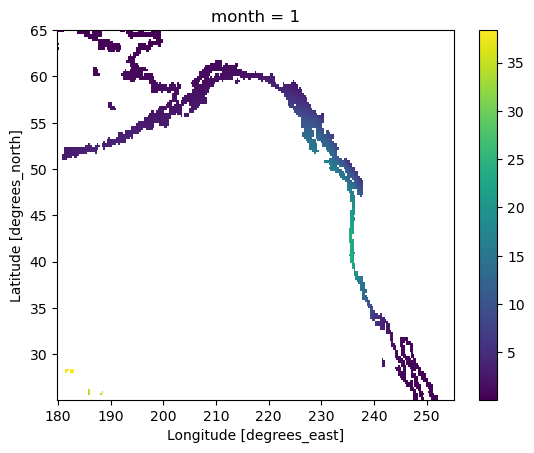

In [31]:
npercentARs_bymonth.where((landfrac > 0) & (landfrac < 0.99)).sel(month=1).plot();

In [32]:
npercentARs_bymonth_coastal_zmean = npercentARs_bymonth.where((landfrac > 0) & (landfrac < 0.99)).sel(lon=slice(230,255)).mean(dim='lon') # same lons as counts at coastlines ARTMIP comparison
npercentARs_bymonth_coastal_zmean

<xarray.DataArray (month: 12, lat: 170)>
dask.array<mean_agg-aggregate, shape=(12, 170), dtype=float64, chunksize=(1, 170), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [33]:
npercentARs_bymonth_coastal_zmean.max().values

array(23.63071237)

/glade/derecho/scratch/kdagon/tmp/ipykernel_25465/39720953.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 12)


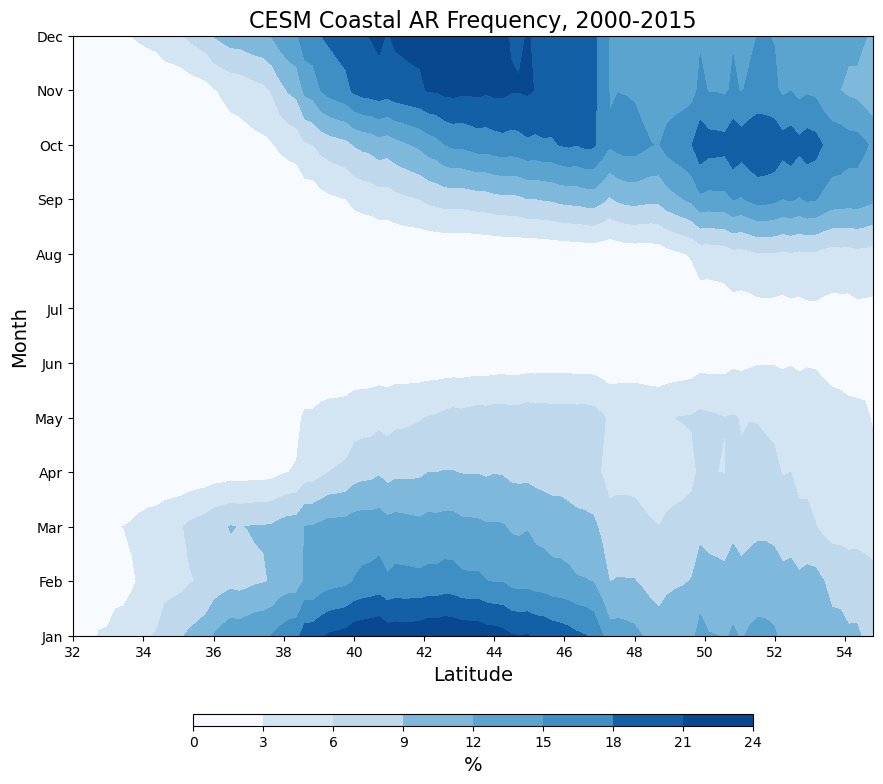

In [96]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)

ax = fig.add_axes([0.,0.,1.,1.])

lat = npercentARs_bymonth_coastal_zmean.lat.sel(lat=slice(32,55)) #artmip lats

mon = npercentARs_bymonth_coastal_zmean.month
# month x lat
pc = ax.contourf(lat, mon, npercentARs_bymonth_coastal_zmean.sel(lat=slice(32,55)), cmap=cmap, vmin=0, vmax=25)

# default is to order Jan-Dec from bottom to top
#ax.set_xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_yticks(np.arange(12)+1, months)

ax.set_ylabel('Month', fontsize=14)

ax.set_xlabel('Latitude', fontsize=14)

# add more latitude labels
lat_labels = np.arange(32, 55, 2)
ax.set_xticks(lat_labels)

# add colorbar
cbar_ax = fig.add_axes([0.15, -0.15, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM Coastal AR Frequency, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_WUS_CESM_hist_rcp26_bymonth_coastal_zmean_artmip-lons-lats.png', bbox_inches='tight')

### RCP8.5

In [35]:
# getting the number of time points in each month
month_lengths_rcp85 = cnet_rcp85.time.groupby('time.month').count()
#month_lengths_rcp85

In [36]:
npercentARs_bymonth_rcp85 = 100*((cnet_rcp85.clip(min=1)-1).groupby('time.month').sum(dim='time'))/month_lengths_rcp85

In [39]:
npercentARs_bymonth_rcp85 = npercentARs_bymonth_rcp85.persist()

In [40]:
npercentARs_bymonth_coastal_zmean_rcp85 = npercentARs_bymonth_rcp85.where((landfrac > 0) & (landfrac < 0.99)).sel(lon=slice(230,255)).mean(dim='lon') # same lons as counts at coastlines ARTMIP comparison
npercentARs_bymonth_coastal_zmean_rcp85

<xarray.DataArray (month: 12, lat: 170)>
dask.array<mean_agg-aggregate, shape=(12, 170), dtype=float64, chunksize=(1, 170), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [41]:
npercentARs_bymonth_coastal_zmean_rcp85.max().values

array(23.02777778)

/glade/derecho/scratch/kdagon/tmp/ipykernel_25465/1431675464.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 12)


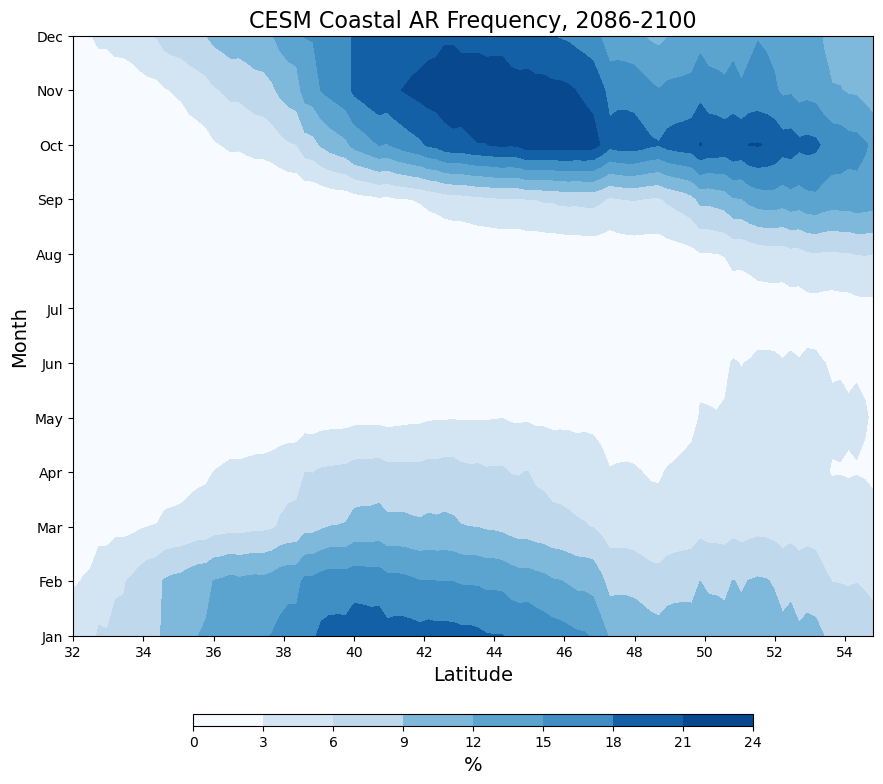

In [95]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)

ax = fig.add_axes([0.,0.,1.,1.])

lat = npercentARs_bymonth_coastal_zmean_rcp85.lat.sel(lat=slice(32,55)) #artmip lats

mon = npercentARs_bymonth_coastal_zmean_rcp85.month
# month x lat
pc = ax.contourf(lat, mon, npercentARs_bymonth_coastal_zmean_rcp85.sel(lat=slice(32,55)), cmap=cmap, vmin=0, vmax=25)

# default is to order Jan-Dec from bottom to top
#ax.set_xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_yticks(np.arange(12)+1, months)

ax.set_ylabel('Month', fontsize=14)

ax.set_xlabel('Latitude', fontsize=14)

# add more latitude labels
lat_labels = np.arange(32, 55, 2)
ax.set_xticks(lat_labels)

# add colorbar
cbar_ax = fig.add_axes([0.15, -0.15, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM Coastal AR Frequency, 2086-2100', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_WUS_CESM_rcp85_bymonth_coastal_zmean_artmip-lons-lats.png', bbox_inches='tight')

### Diffs

In [43]:
npercentARs_bymonth_coastal_zmean_diff = npercentARs_bymonth_coastal_zmean_rcp85 - npercentARs_bymonth_coastal_zmean
print(npercentARs_bymonth_coastal_zmean_diff.min().values,
      npercentARs_bymonth_coastal_zmean_diff.max().values)

-5.016241039426522 5.140288978494624


/glade/derecho/scratch/kdagon/tmp/ipykernel_25465/3692902819.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('seismic')


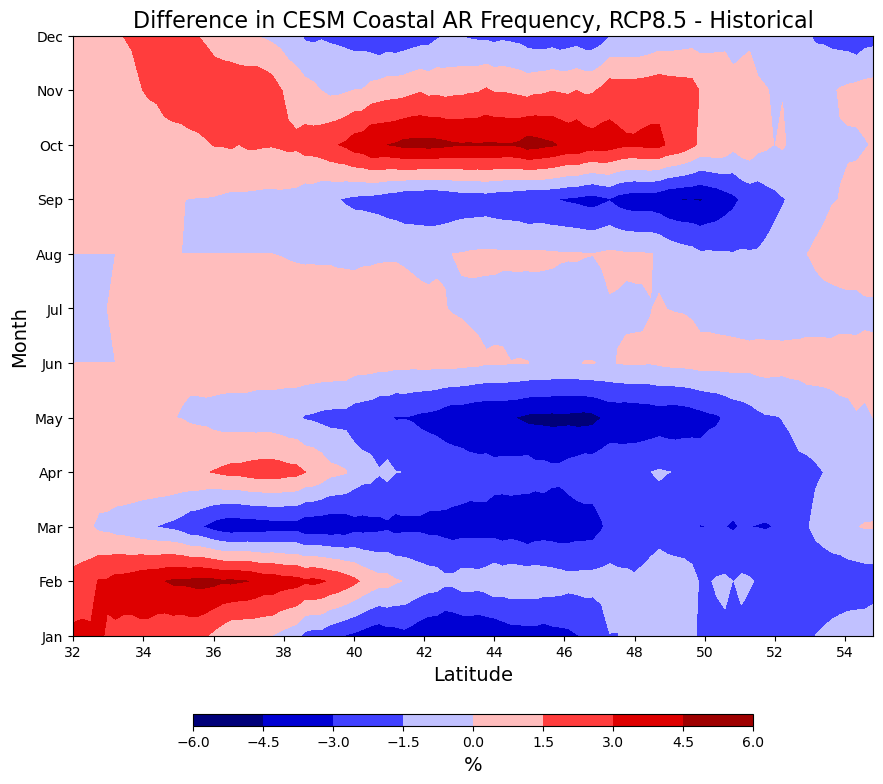

In [102]:
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('seismic')

ax = fig.add_axes([0.,0.,1.,1.])

#lon=slice(230,255) # artmip
#lat_bounds = slice(32,55) # counts at coastlines

lat = npercentARs_bymonth_coastal_zmean_diff.lat.sel(lat=slice(32,55)) #artmip lats
mon = npercentARs_bymonth_coastal_zmean_diff.month
pc = ax.contourf(lat, mon, npercentARs_bymonth_coastal_zmean_diff.sel(lat=slice(32,55)), cmap=cmap, vmin=-6, vmax=6) #month x lat

ax.set_yticks(np.arange(12)+1, months)

ax.set_ylabel('Month', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)

# add more latitude labels
lat_labels = np.arange(32, 55, 2)
ax.set_xticks(lat_labels)

# add colorbar
cbar_ax = fig.add_axes([0.15, -0.15, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('Difference in CESM Coastal AR Frequency, RCP8.5 - Historical', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_CESM_diff_bymonth_coastal_zmean_artmip-box.png', bbox_inches='tight')

## MERRA-2

In [45]:
merra_cnet_path = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier1/ClimateNet_DL/' # tier1, 3hrly
#merra_cnet_path = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier2/MERRA2_native/climatenet/' # tier2, 1hrly

In [46]:
file_years = '*.20[00-15]*' # not a perfect wildcard, but captures 2000 - 2017 (or 2019 for tier2)
#file_years = '*.nc4' # for all years; 1980 - June 2017

### Preprocessing function to (optionally) subset regionally

In [63]:
# MERRA2 lons are -180 / +180
lat_bounds_merra = slice(25,65)
lon_bounds_merra = slice(-180,-105)
#lat_bounds_merra = slice(32,55) # artmip lats
#lon_bounds_merra = slice(-130,-105) # artmip lons

# CESM bounds used above (for reference)
#lat_bounds = slice(25,65)
#lon_bounds = slice(180,255)

In [64]:
def preprocess_region_merra(ds):
    # return regional domain
    return ds['ar_binary_tag'].sel(lat=lat_bounds_merra,lon=lon_bounds_merra)

### Read in data

In [65]:
#merra_cnet = xr.open_mfdataset(merra_cnet_path+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True)
merra_cnet = xr.open_mfdataset(merra_cnet_path+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region_merra)
merra_cnet

<xarray.DataArray 'ar_binary_tag' (time: 51128, lat: 81, lon: 121)>
dask.array<concatenate, shape=(51128, 81, 121), dtype=int8, chunksize=(500, 81, 121), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... -106.2 -105.6 -105.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2017-06-30T21:00:00
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  binary indicator of atmospheric river

In [66]:
# if not using preprocess
#merra_ar_full = merra_cnet.ar_binary_tag

# otherwise
merra_ar_full = merra_cnet
#merra_ar_full

In [67]:
# subset 2000-2015 to match CESM years (number of time indices will not match due to CESM shifted start and MERRA leap years)
merra_ar = merra_ar_full.sel(time=slice("2000","2015"))

# or look at all years
#merra_ar = merra_ar_full

merra_ar

<xarray.DataArray 'ar_binary_tag' (time: 46752, lat: 81, lon: 121)>
dask.array<getitem, shape=(46752, 81, 121), dtype=int8, chunksize=(500, 81, 121), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... -106.2 -105.6 -105.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2015-12-31T21:00:00
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  binary indicator of atmospheric river

### MERRA landfrac
Actually stored as 'ocnfrac'\
CGD machines: `/project/ccr/shields/merra2/merra2_ocn_land_fraction.nc`\
CISL machines: `/glade/derecho/scratch/shields/ARTMIP/grids/merra2_ocn_land_fraction.nc`

In [74]:
merra_landfrac_file = "/glade/derecho/scratch/shields/ARTMIP/grids/merra2_ocn_land_fraction.nc"
merra_landfrac_ds = xr.open_dataset(merra_landfrac_file)
#merra_landfrac_ds

In [75]:
merra_landfrac = 1-(merra_landfrac_ds.ocnfrac.sel(lat=lat_bounds_merra,lon=lon_bounds_merra))
#merra_landfrac

### Hovmollers

In [76]:
# getting the number of time points in each month
month_lengths_merra = merra_ar.time.groupby('time.month').count()
#month_lengths_merra

In [77]:
npercentARs_bymonth_merra = 100*(merra_ar.groupby('time.month').sum(dim='time'))/month_lengths_merra

In [78]:
npercentARs_bymonth_merra = npercentARs_bymonth_merra.persist()

### Use landfrac to define coastal ARs
Are these longitude bounds too narrow? How to define "landfalling ARs"

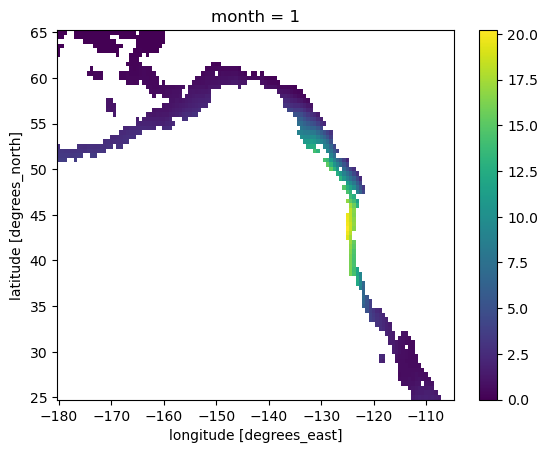

In [79]:
npercentARs_bymonth_merra.where((merra_landfrac > 0) & (merra_landfrac < 0.99)).sel(month=1).plot();

In [80]:
npercentARs_bymonth_coastal_zmean_merra = npercentARs_bymonth_merra.where((merra_landfrac > 0) & (merra_landfrac < 0.99)).sel(lon=slice(-130,-105)).mean(dim='lon') # same lons as counts at coastlines ARTMIP comparison
npercentARs_bymonth_coastal_zmean_merra

<xarray.DataArray (month: 12, lat: 81)>
dask.array<mean_agg-aggregate, shape=(12, 81), dtype=float64, chunksize=(1, 81), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [81]:
npercentARs_bymonth_coastal_zmean_merra.max().values

array(22.5390625)

/glade/derecho/scratch/kdagon/tmp/ipykernel_25465/891868268.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 12)


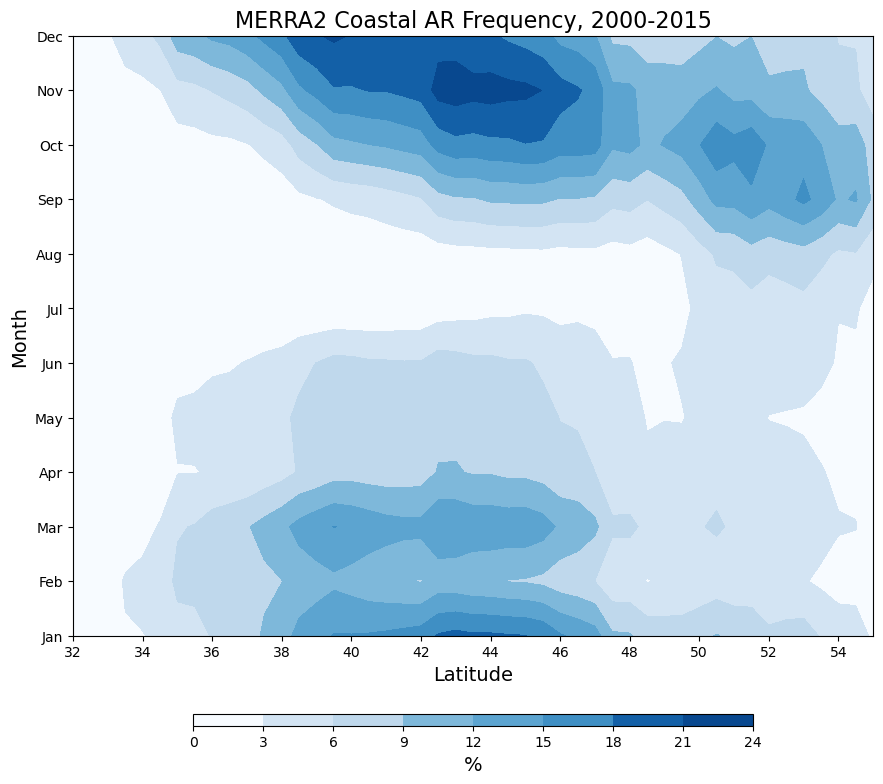

In [94]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)

ax = fig.add_axes([0.,0.,1.,1.])

lat = npercentARs_bymonth_coastal_zmean_merra.lat.sel(lat=slice(32,55)) #artmip lats

mon = npercentARs_bymonth_coastal_zmean_merra.month
# month x lat
pc = ax.contourf(lat, mon, npercentARs_bymonth_coastal_zmean_merra.sel(lat=slice(32,55)), cmap=cmap, vmin=0, vmax=25)

# default is to order Jan-Dec from bottom to top
#ax.set_xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_yticks(np.arange(12)+1, months)

ax.set_ylabel('Month', fontsize=14)

ax.set_xlabel('Latitude', fontsize=14)

# add more latitude labels
lat_labels = np.arange(32, 55, 2)
ax.set_xticks(lat_labels)

# add colorbar
cbar_ax = fig.add_axes([0.15, -0.15, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('MERRA2 Coastal AR Frequency, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_WUS_MERRA2_bymonth_coastal_zmean.png', bbox_inches='tight')

## Remap CESM to MERRA grid to calculate diff

### Regridding

In [83]:
%%time
regridder = xe.Regridder(npercentARs_bymonth, npercentARs_bymonth_merra, "bilinear") # don't use periodic=True here because its a region
regridder

CPU times: user 413 ms, sys: 17.8 ms, total: 431 ms
Wall time: 448 ms


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_170x241_81x121.nc 
Reuse pre-computed weights? False 
Input grid shape:           (170, 241) 
Output grid shape:          (81, 121) 
Periodic in longitude?      False

In [84]:
%%time
npercentARs_bymonth_merragrid = regridder(npercentARs_bymonth, keep_attrs=True)
npercentARs_bymonth_merragrid

CPU times: user 1.96 s, sys: 237 ms, total: 2.2 s
Wall time: 5 s


<xarray.DataArray (month: 12, lat: 81, lon: 121)>
dask.array<sum-aggregate, shape=(12, 81, 121), dtype=float64, chunksize=(1, 81, 121), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... -106.2 -105.6 -105.0
Attributes:
    regrid_method:  bilinear

In [85]:
npercentARs_bymonth_merragrid = npercentARs_bymonth_merragrid.persist()

### Use MERRA landfrac to define coastal ARs
Are these longitude bounds too narrow? How to define "landfalling ARs"

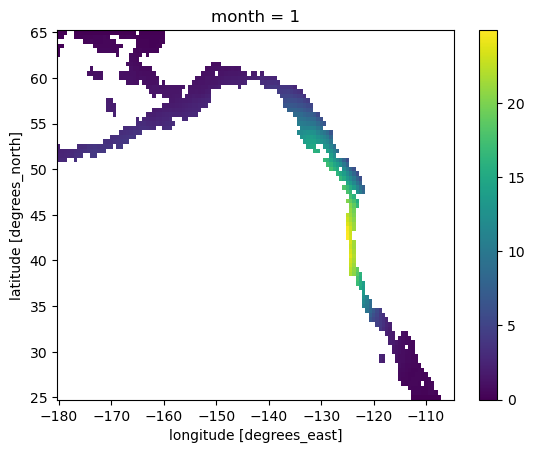

In [87]:
npercentARs_bymonth_merragrid.where((merra_landfrac > 0) & (merra_landfrac < 0.99)).sel(month=1).plot();

In [88]:
npercentARs_bymonth_coastal_zmean_merragrid = npercentARs_bymonth_merragrid.where((merra_landfrac > 0) & (merra_landfrac < 0.99)).sel(lon=slice(-130,-105)).mean(dim='lon') # same lons as counts at coastlines ARTMIP comparison
npercentARs_bymonth_coastal_zmean_merragrid

<xarray.DataArray (month: 12, lat: 81)>
dask.array<mean_agg-aggregate, shape=(12, 81), dtype=float64, chunksize=(1, 81), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0

In [89]:
npercentARs_bymonth_coastal_zmean_merragrid.max().values

array(24.10079566)

/glade/derecho/scratch/kdagon/tmp/ipykernel_25465/2126014622.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 12)


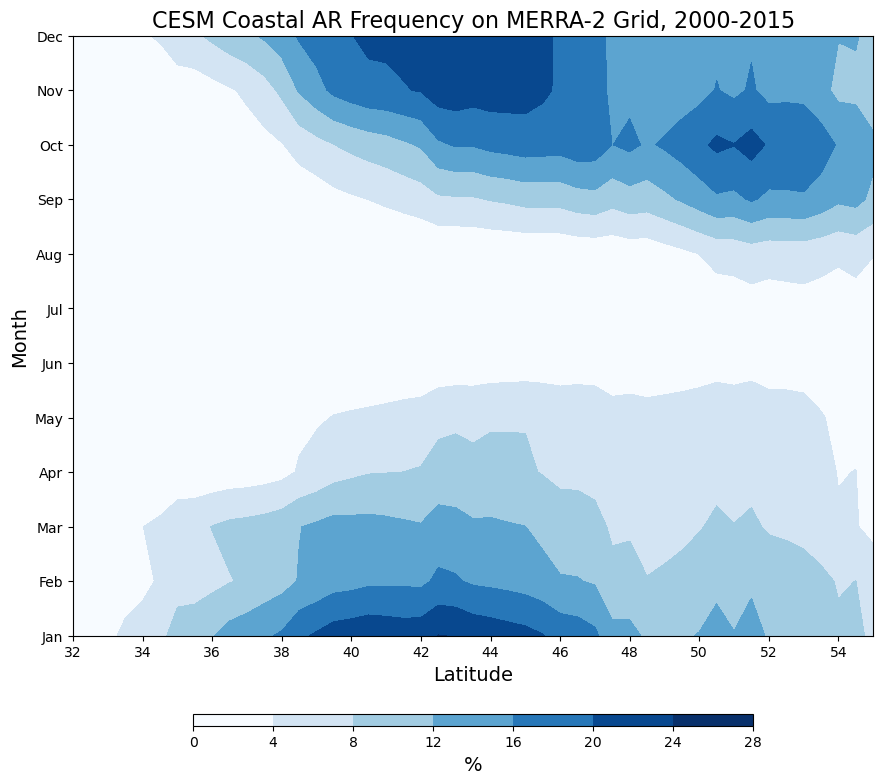

In [93]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)

ax = fig.add_axes([0.,0.,1.,1.])

lat = npercentARs_bymonth_coastal_zmean_merragrid.lat.sel(lat=slice(32,55)) #artmip lats

mon = npercentARs_bymonth_coastal_zmean_merragrid.month
# month x lat
pc = ax.contourf(lat, mon, npercentARs_bymonth_coastal_zmean_merragrid.sel(lat=slice(32,55)), cmap=cmap, vmin=0, vmax=25)

# default is to order Jan-Dec from bottom to top
#ax.set_xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_yticks(np.arange(12)+1, months)

ax.set_ylabel('Month', fontsize=14)

ax.set_xlabel('Latitude', fontsize=14)

# add more latitude labels
lat_labels = np.arange(32, 55, 2)
ax.set_xticks(lat_labels)

# add colorbar
cbar_ax = fig.add_axes([0.15, -0.15, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM Coastal AR Frequency on MERRA-2 Grid, 2000-2015', fontsize=16); 

### Diffs

In [98]:
npercentARs_bymonth_coastal_zmean_merra_diff = npercentARs_bymonth_coastal_zmean_merra - npercentARs_bymonth_coastal_zmean_merragrid
print(npercentARs_bymonth_coastal_zmean_merra_diff.min().values,
      npercentARs_bymonth_coastal_zmean_merra_diff.max().values)

-7.645231223080563 5.8253752099212


/glade/derecho/scratch/kdagon/tmp/ipykernel_25465/1665574311.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('seismic')


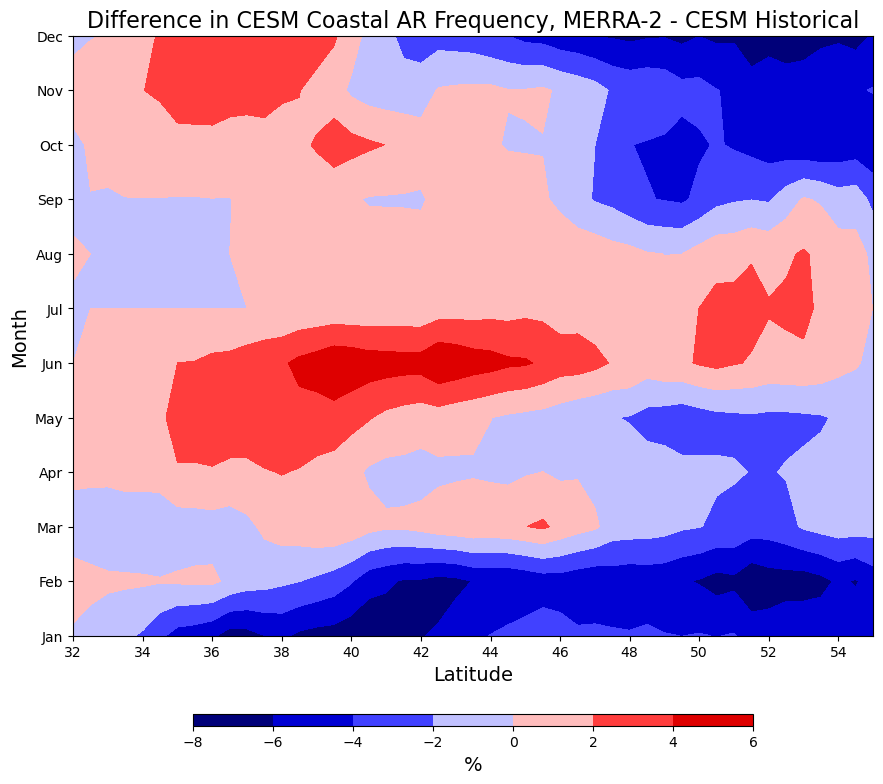

In [100]:
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('seismic')

ax = fig.add_axes([0.,0.,1.,1.])

#lon=slice(230,255) # artmip
#lat_bounds = slice(32,55) # counts at coastlines

lat = npercentARs_bymonth_coastal_zmean_merra_diff.lat.sel(lat=slice(32,55)) #artmip lats
mon = npercentARs_bymonth_coastal_zmean_merra_diff.month
pc = ax.contourf(lat, mon, npercentARs_bymonth_coastal_zmean_merra_diff.sel(lat=slice(32,55)), cmap=cmap, vmin=-8, vmax=8) #month x lat

ax.set_yticks(np.arange(12)+1, months)

ax.set_ylabel('Month', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)

# add more latitude labels
lat_labels = np.arange(32, 55, 2)
ax.set_xticks(lat_labels)

# add colorbar
cbar_ax = fig.add_axes([0.15, -0.15, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('Difference in CESM Coastal AR Frequency, MERRA-2 - CESM Historical', fontsize=16); 

## Panel plot

In [91]:
print('Absolute max values are ', npercentARs_bymonth_coastal_zmean.max().values, npercentARs_bymonth_coastal_zmean_rcp85.max().values, npercentARs_bymonth_coastal_zmean_merra.max().values)

Absolute max values are  23.630712365591396 23.02777777777778 22.5390625


In [103]:
print('Diff min values are ', npercentARs_bymonth_coastal_zmean_diff.min().values, npercentARs_bymonth_coastal_zmean_merra_diff.min().values)
print('Diff max values are ', npercentARs_bymonth_coastal_zmean_diff.max().values, npercentARs_bymonth_coastal_zmean_merra_diff.max().values)

Diff min values are  -5.016241039426522 -7.645231223080563
Diff max values are  5.140288978494624 5.8253752099212


/glade/derecho/scratch/kdagon/tmp/ipykernel_25465/189886053.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 16)
/glade/derecho/scratch/kdagon/tmp/ipykernel_25465/189886053.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_d = plt.cm.get_cmap('seismic')


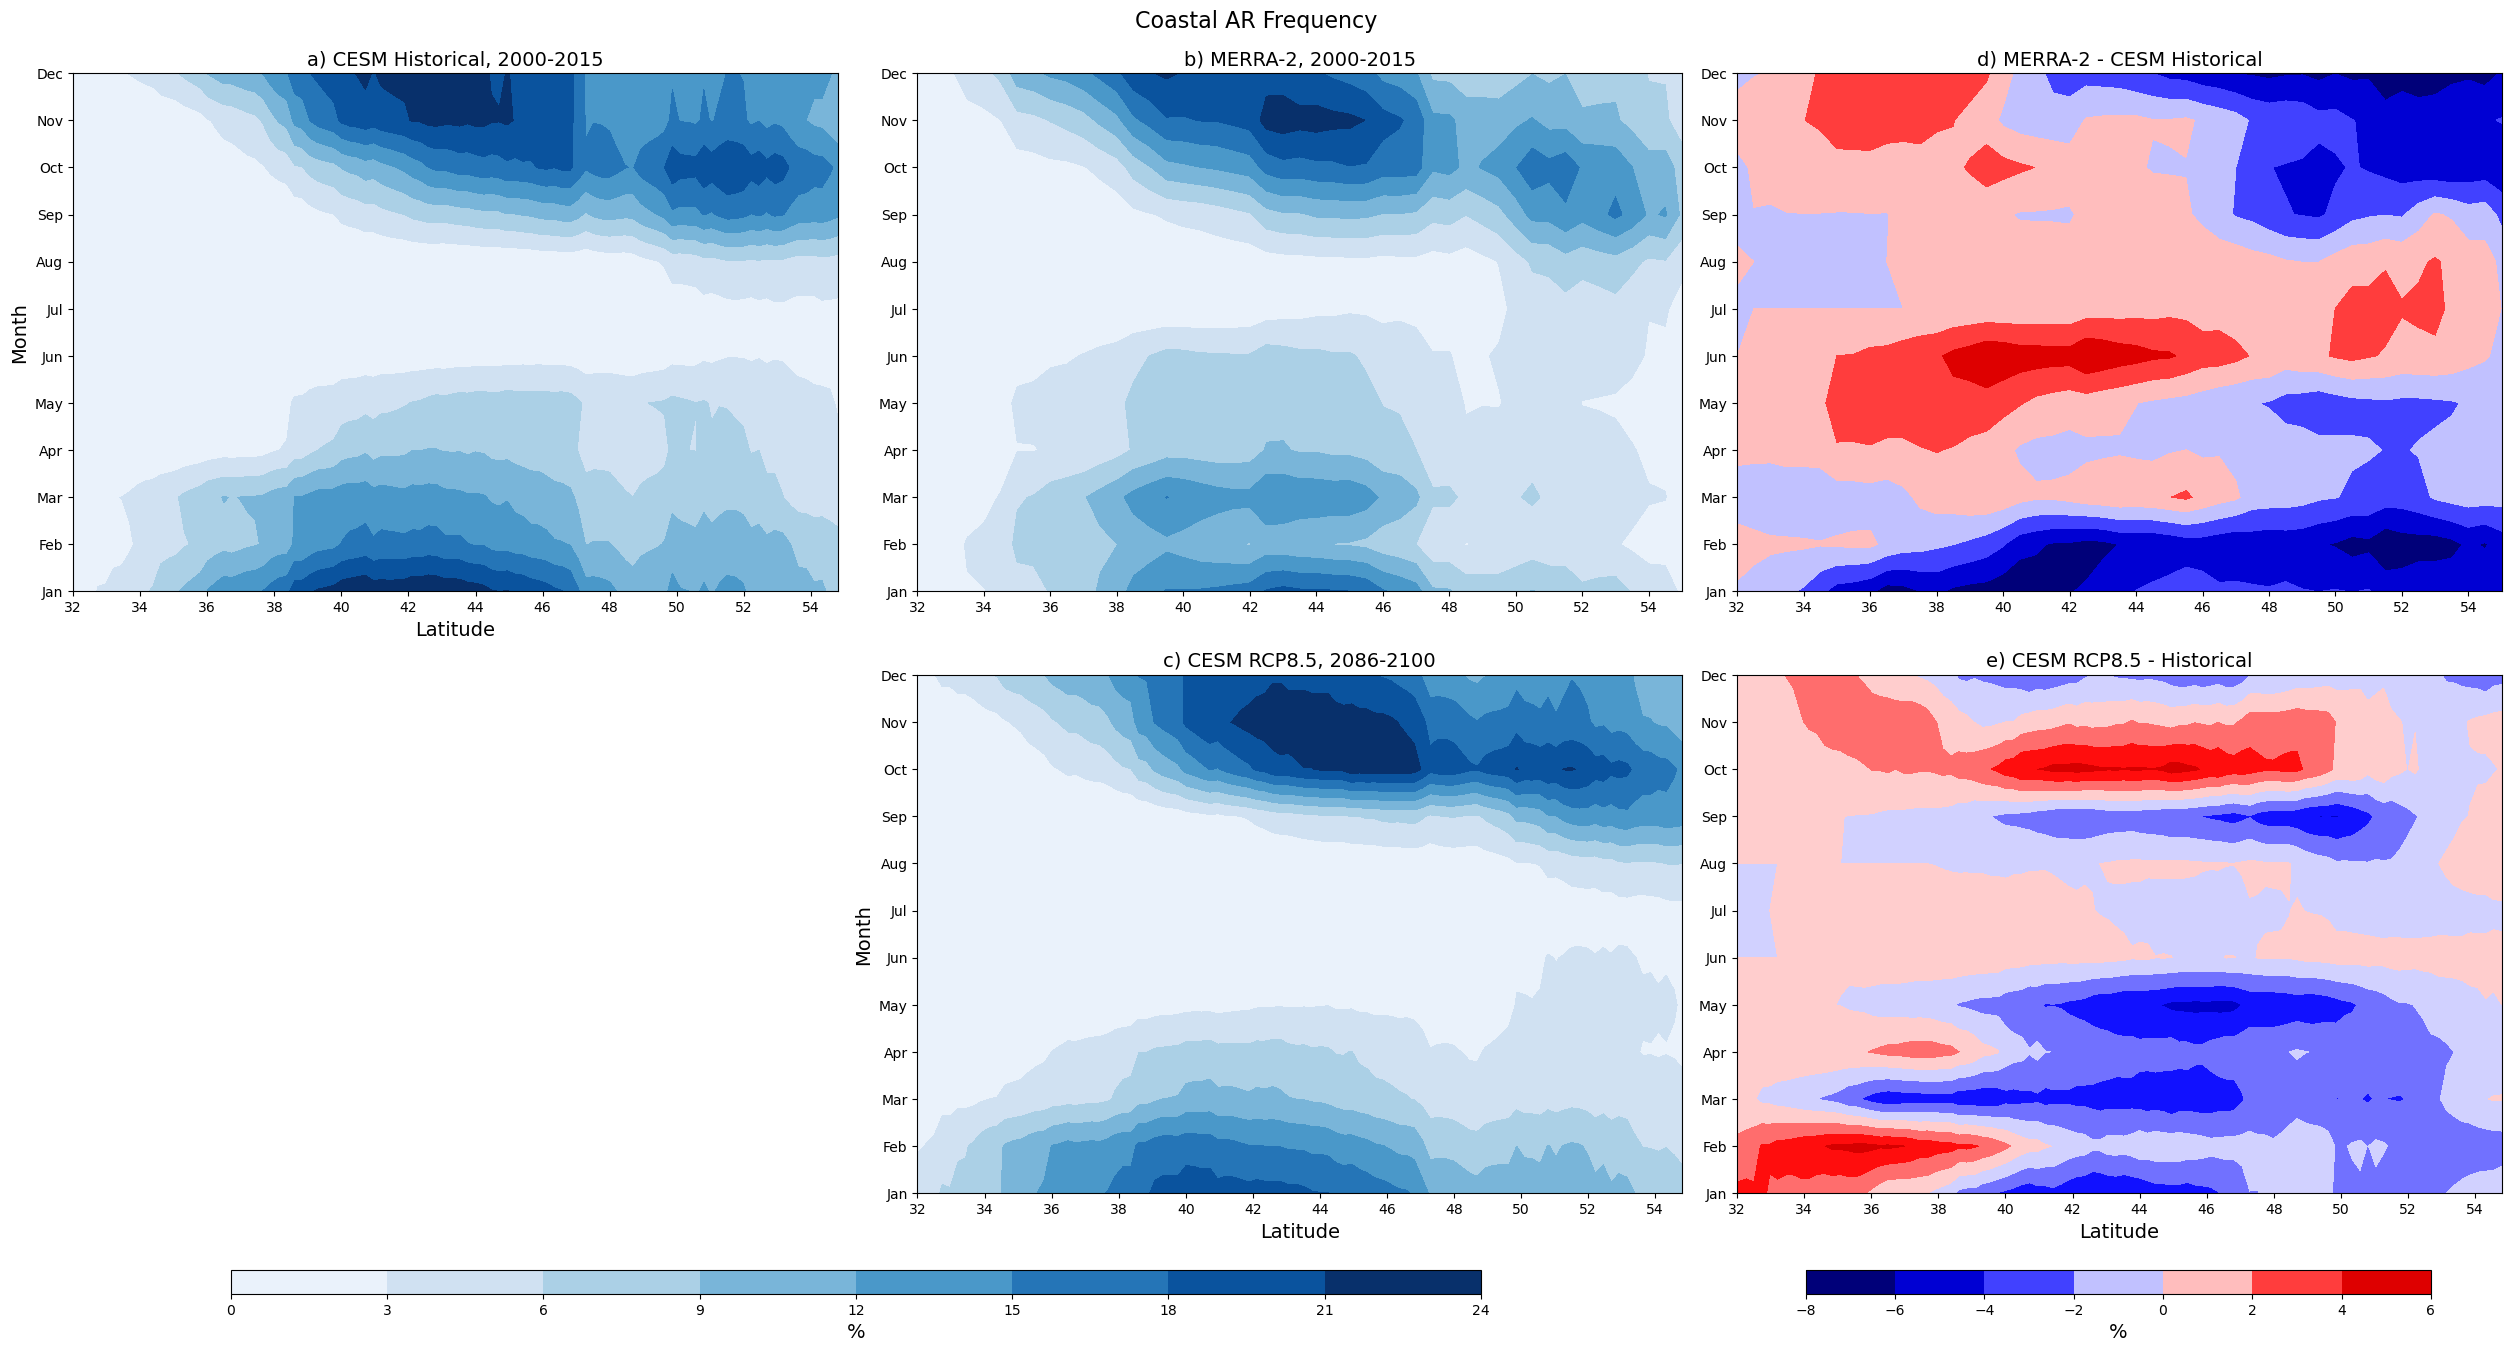

In [115]:
fig, ax = plt.subplot_mosaic([['upper left', 'upper middle', 'upper right'],
                               ['.', 'lower middle', 'lower right']],
                              figsize=(25,12), layout="constrained")

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
lat_labels = np.arange(32, 55, 2)

# colormap/bounds for absolute plots
cmap=plt.cm.get_cmap('Blues', 16)
vmin_a = 0
vmax_a = 24

# CESM Historical
lat = npercentARs_bymonth_coastal_zmean.lat.sel(lat=slice(32,55)) #artmip lats
mon = npercentARs_bymonth_coastal_zmean.month
cf1 = ax['upper left'].contourf(lat, mon, npercentARs_bymonth_coastal_zmean.sel(lat=slice(32,55)), cmap=cmap, vmin=vmin_a, vmax=vmax_a)
ax['upper left'].set_yticks(np.arange(12)+1, months)
ax['upper left'].set_ylabel('Month', fontsize=14)
ax['upper left'].set_xlabel('Latitude', fontsize=14)
ax['upper left'].set_xticks(lat_labels)
ax['upper left'].set_title('a) CESM Historical, 2000-2015', fontsize=14)

# MERRA2
lat = npercentARs_bymonth_coastal_zmean_merra.lat.sel(lat=slice(32,55))
mon = npercentARs_bymonth_coastal_zmean_merra.month
cf2 = ax['upper middle'].contourf(lat, mon, npercentARs_bymonth_coastal_zmean_merra.sel(lat=slice(32,55)), cmap=cmap, vmin=vmin_a, vmax=vmax_a)
ax['upper middle'].set_yticks(np.arange(12)+1, months)
#ax['upper middle'].set_ylabel('Month', fontsize=14)
#ax['upper middle'].set_xlabel('Latitude', fontsize=14)
ax['upper middle'].set_xticks(lat_labels)
ax['upper middle'].set_title('b) MERRA-2, 2000-2015', fontsize=14)

# CESM RCP8.5
lat = npercentARs_bymonth_coastal_zmean_rcp85.lat.sel(lat=slice(32,55))
mon = npercentARs_bymonth_coastal_zmean_rcp85.month
cf3 = ax['lower middle'].contourf(lat, mon, npercentARs_bymonth_coastal_zmean_rcp85.sel(lat=slice(32,55)), cmap=cmap, vmin=vmin_a, vmax=vmax_a)
ax['lower middle'].set_yticks(np.arange(12)+1, months)
ax['lower middle'].set_ylabel('Month', fontsize=14)
ax['lower middle'].set_xlabel('Latitude', fontsize=14)
ax['lower middle'].set_xticks(lat_labels)
ax['lower middle'].set_title('c) CESM RCP8.5, 2086-2100', fontsize=14)

# colormap/bounds for diff plots
cmap_d = plt.cm.get_cmap('seismic')
vmin_d = -8
vmax_d = 8

# MERRA - CESM Hist (remapped)
lat = npercentARs_bymonth_coastal_zmean_merra_diff.lat.sel(lat=slice(32,55))
mon = npercentARs_bymonth_coastal_zmean_merra_diff.month
cf4 = ax['upper right'].contourf(lat, mon, npercentARs_bymonth_coastal_zmean_merra_diff.sel(lat=slice(32,55)), cmap=cmap_d, vmin=vmin_d, vmax=vmax_d)
ax['upper right'].set_yticks(np.arange(12)+1, months)
#ax['upper right'].set_ylabel('Month', fontsize=14)
#ax['upper right'].set_xlabel('Latitude', fontsize=14)
ax['upper right'].set_xticks(lat_labels)
ax['upper right'].set_title('d) MERRA-2 - CESM Historical', fontsize=14)

# CESM RCP - Historical
lat = npercentARs_bymonth_coastal_zmean_diff.lat.sel(lat=slice(32,55))
mon = npercentARs_bymonth_coastal_zmean_diff.month
cf5 = ax['lower right'].contourf(lat, mon, npercentARs_bymonth_coastal_zmean_diff.sel(lat=slice(32,55)), cmap=cmap_d, vmin=vmin_d, vmax=vmax_d)
ax['lower right'].set_yticks(np.arange(12)+1, months)
#ax['lower right'].set_ylabel('Month', fontsize=14)
ax['lower right'].set_xlabel('Latitude', fontsize=14)
ax['lower right'].set_xticks(lat_labels)
ax['lower right'].set_title('e) CESM RCP8.5 - Historical', fontsize=14)


# add colorbar for absolute plots
cbar_ax = fig.add_axes([0.09, -0.04, 0.5, 0.02]) #left,bottom,width,height
cbar = plt.colorbar(cf1, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add colorbar for diff plots
cbar_d_ax = fig.add_axes([0.72, -0.04, 0.25, 0.02])
cbar_d = plt.colorbar(cf4, cax=cbar_d_ax, orientation='horizontal')
cbar_d.ax.set_xlabel('%', fontsize=14);

# add suptitle
fig.suptitle('Coastal AR Frequency', fontsize=16, y=1.03);

#plt.savefig('../figures/toSCP/npercentARs_WUS_CESM_MERRA_allplots_bymonth_coastal_zmean.png', bbox_inches='tight', dpi=300)

### Close cluster/client as needed

In [116]:
client.close()
cluster.close()